
⎯⎯⎯⎯ Sector 1 ⎯⎯⎯⎯
Sector: 1


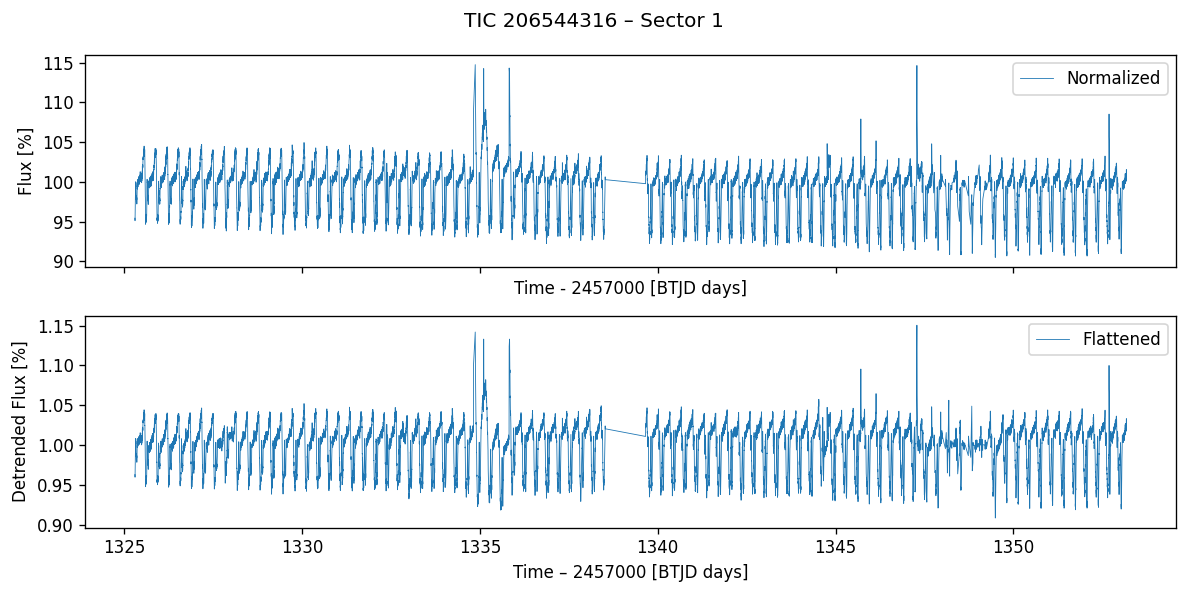

Best LS period: 0.3216 ±  0.001859 days


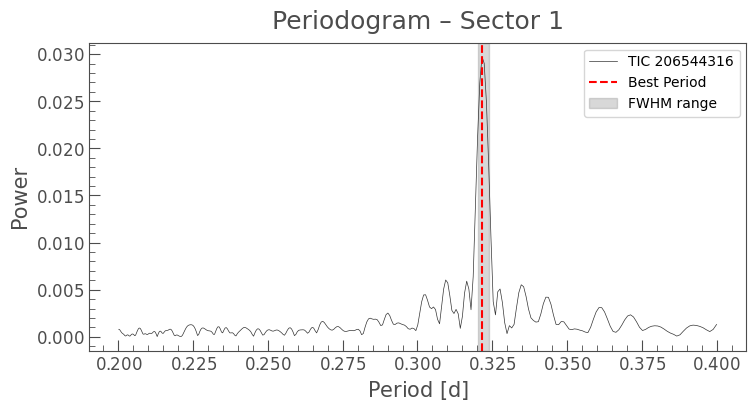


⎯⎯⎯⎯ Sector 2 ⎯⎯⎯⎯
Sector: 2


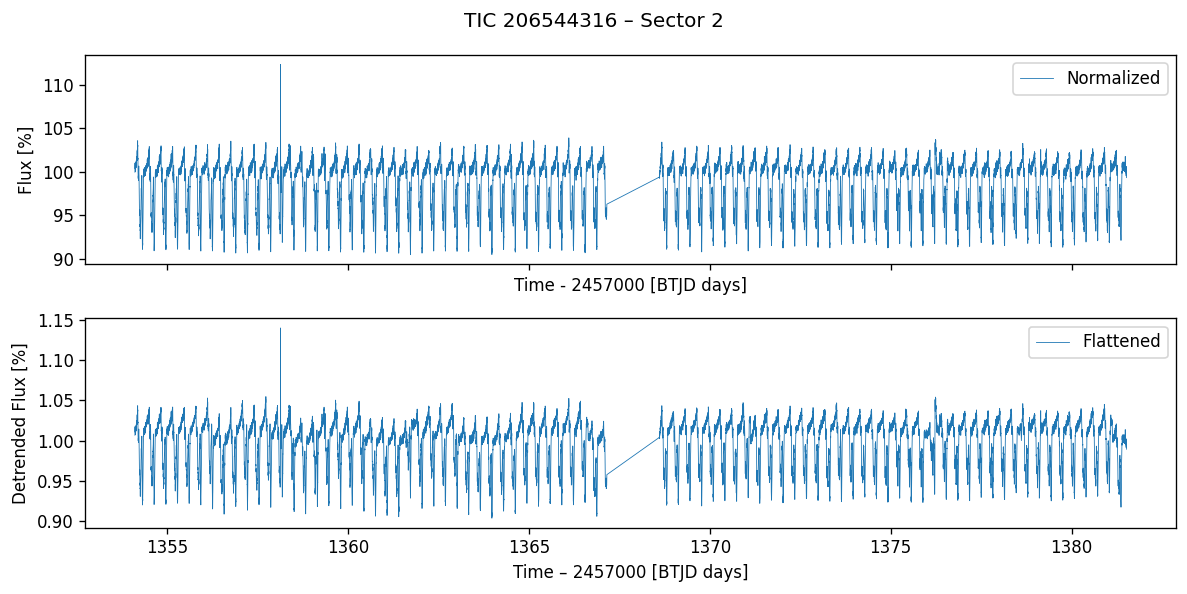

Best LS period: 0.3220 ±  0.001887 days


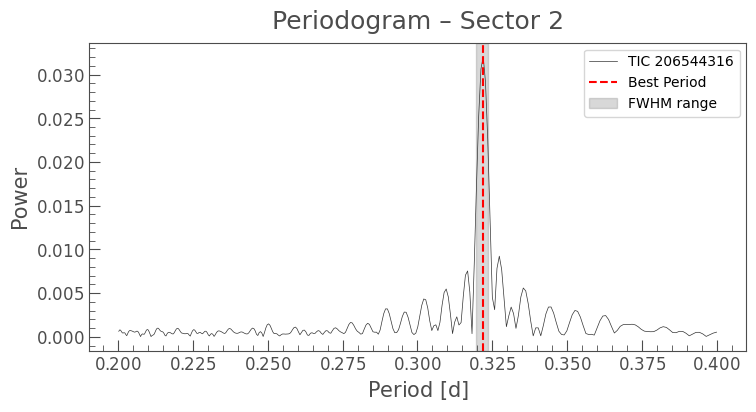


⎯⎯⎯⎯ Sector 3 ⎯⎯⎯⎯
Sector: 28


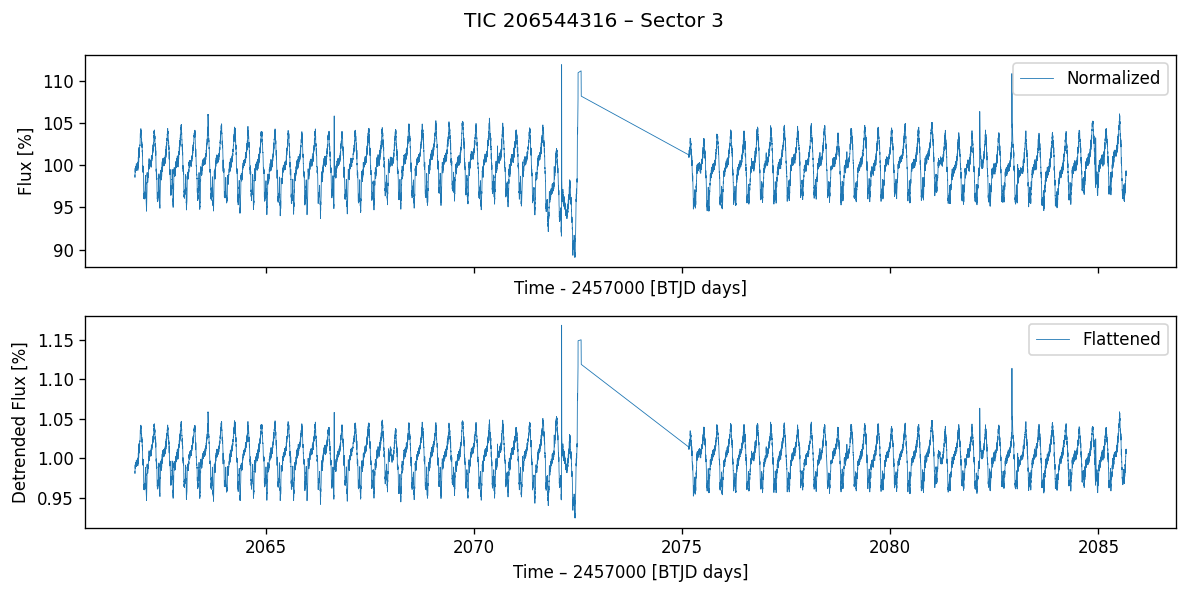

Best LS period: 0.3221 ±  0.001742 days


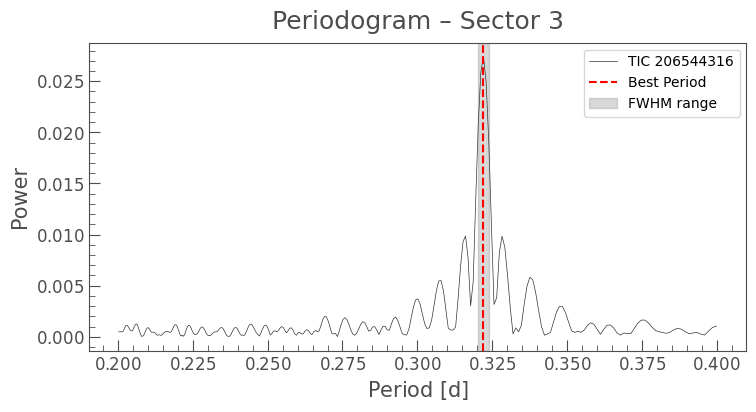


⎯⎯⎯⎯ Sector 4 ⎯⎯⎯⎯
Sector: 29


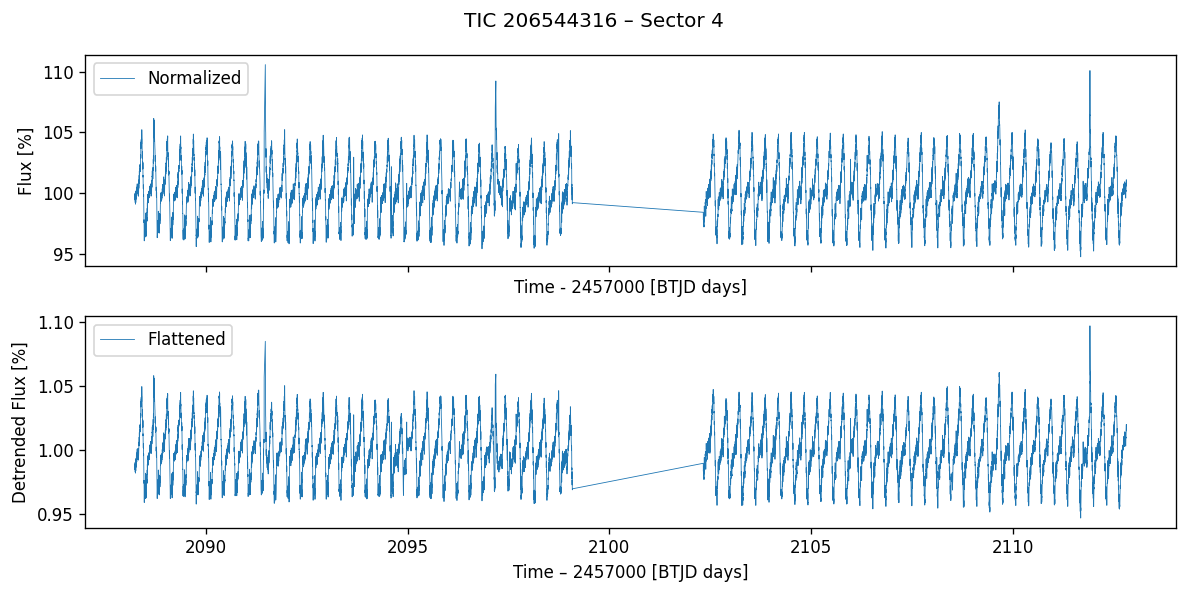

Best LS period: 0.3223 ±  0.002109 days


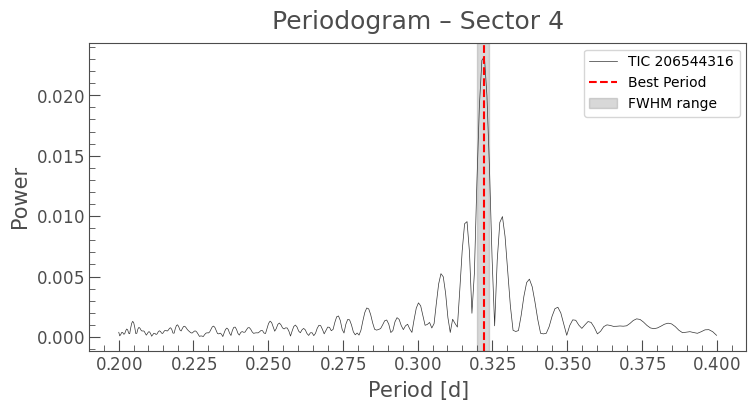


⎯⎯⎯⎯ Sector 5 ⎯⎯⎯⎯
Sector: 68


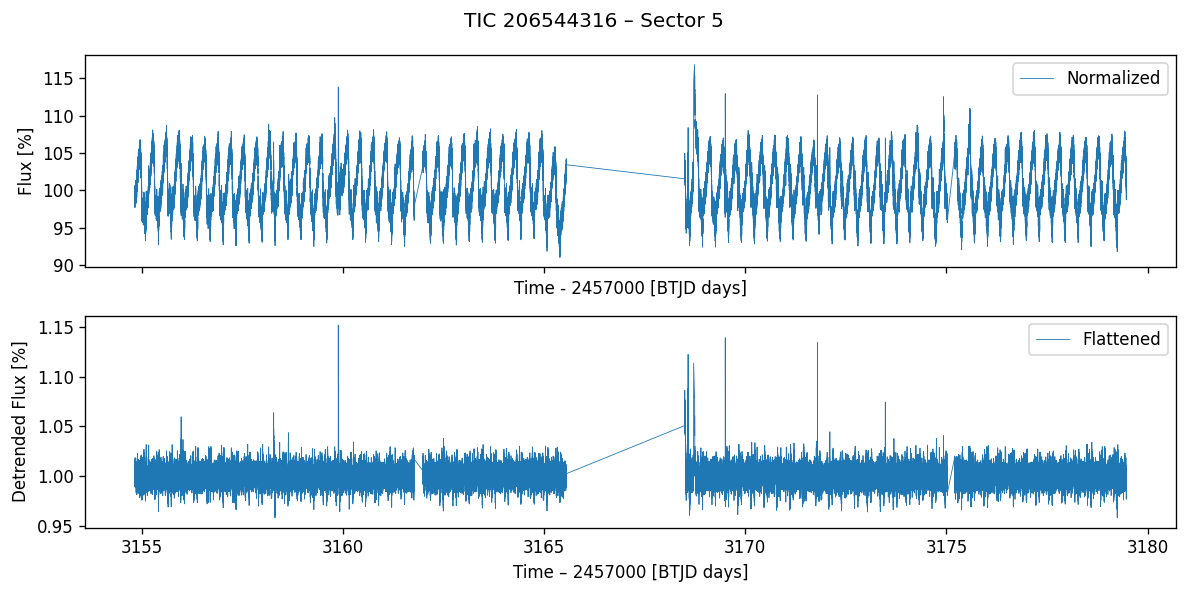

Best LS period: 0.2054 ±  0.096791 days


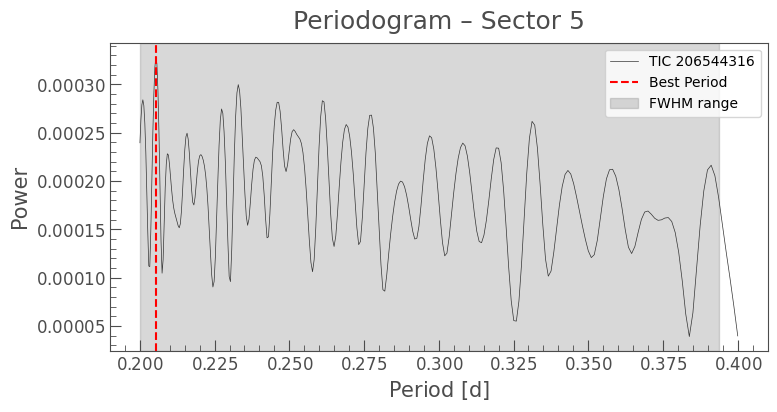


⎯⎯⎯⎯ Sector 6 ⎯⎯⎯⎯
Sector: 69


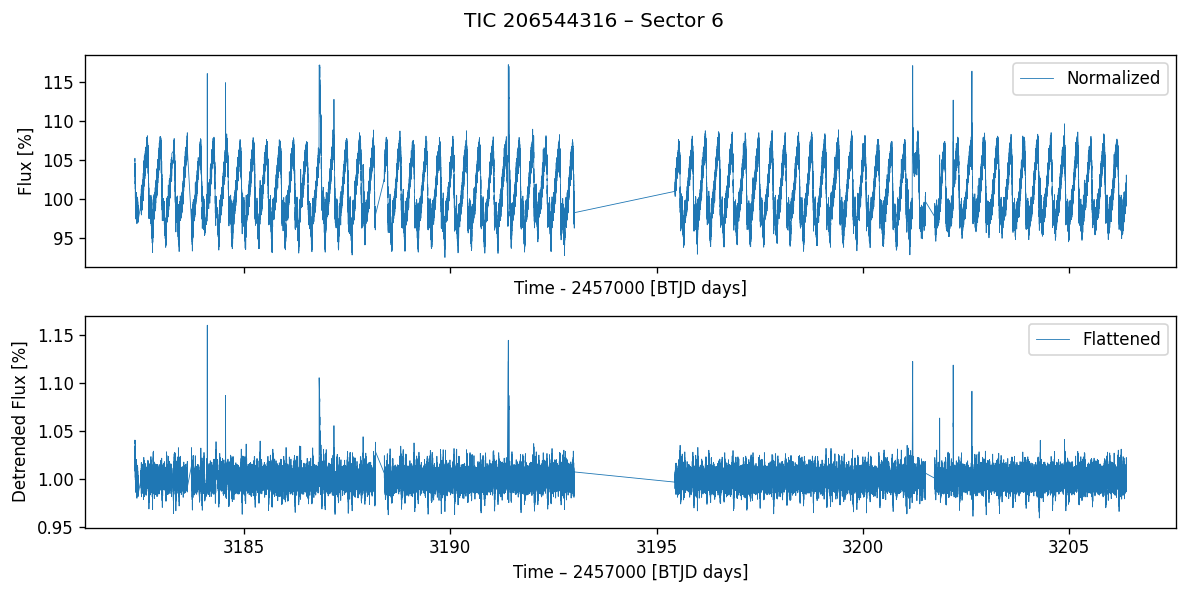

Best LS period: 0.3201 ±  0.080140 days


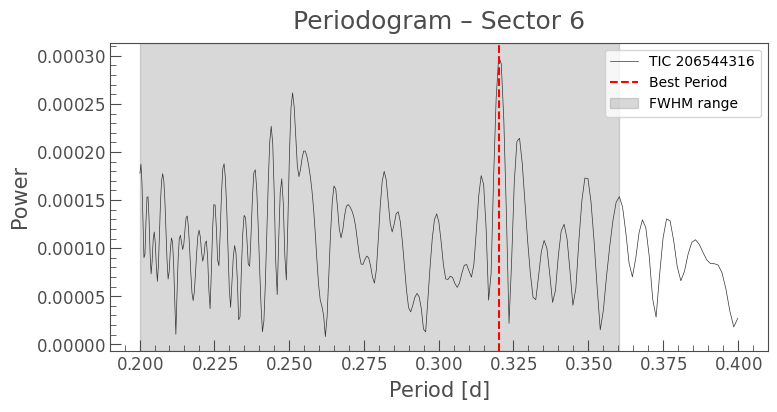


⎯⎯⎯⎯ Sector 7 ⎯⎯⎯⎯
Sector: 68


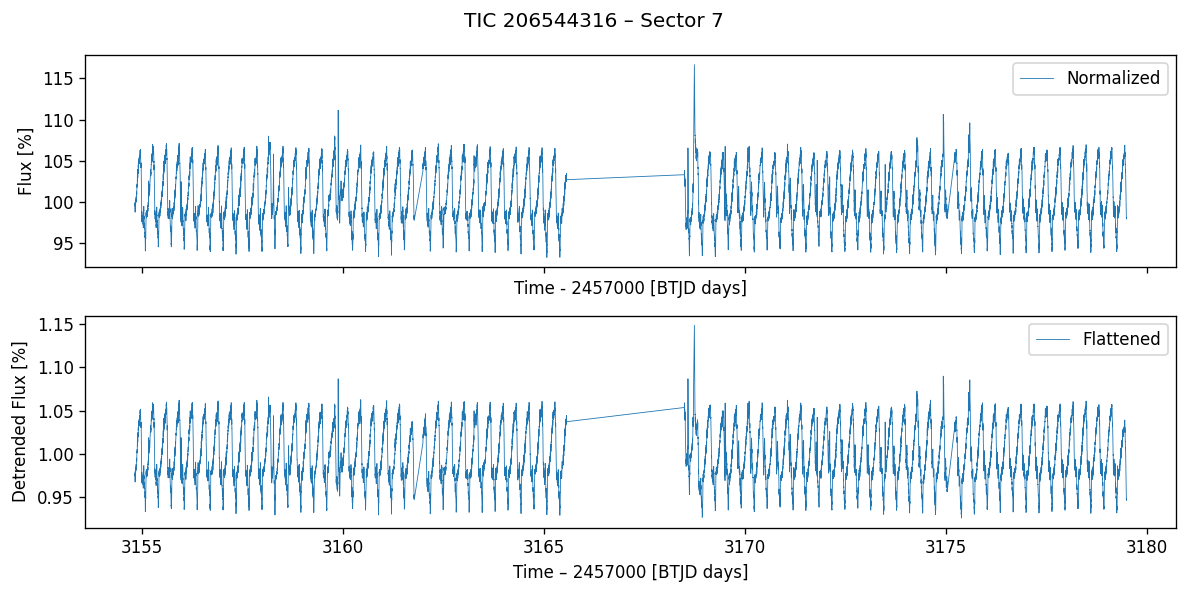

Best LS period: 0.3217 ±  0.002105 days


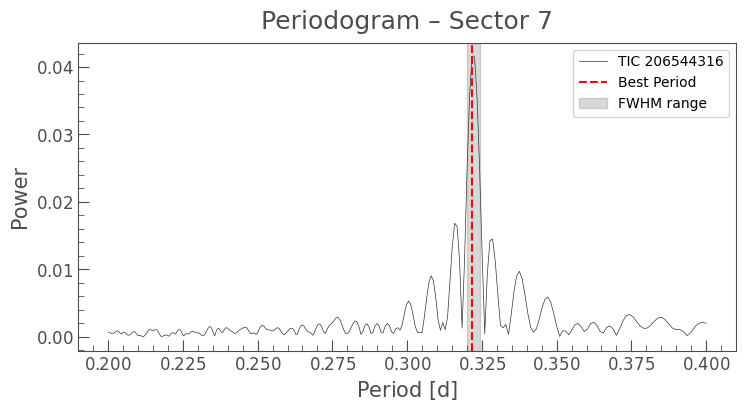


⎯⎯⎯⎯ Sector 8 ⎯⎯⎯⎯
Sector: 69


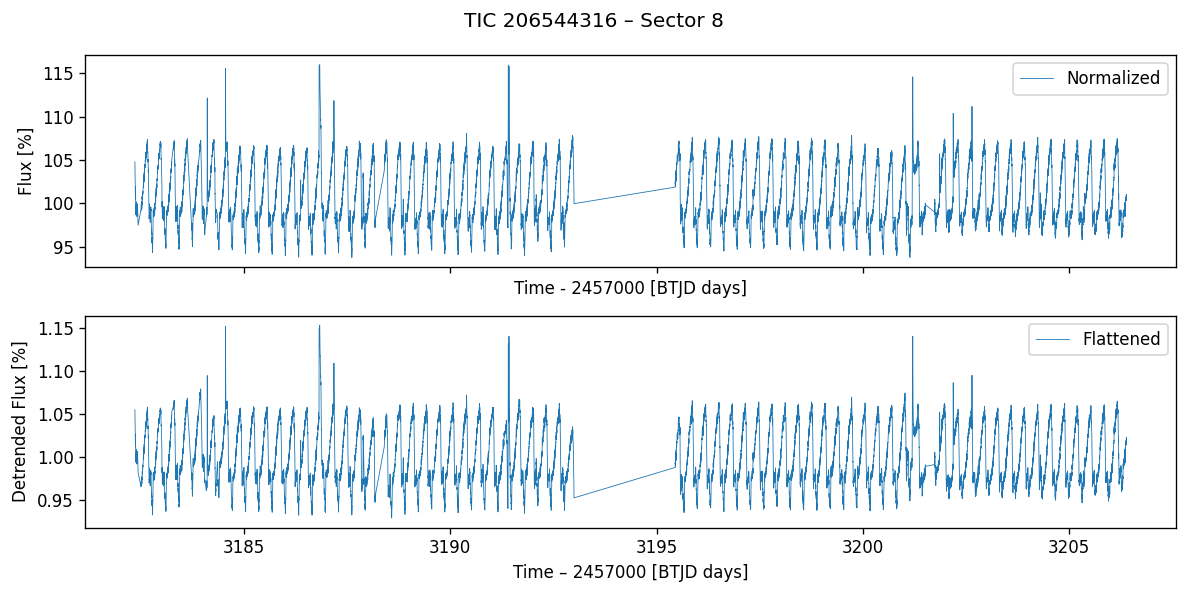

Best LS period: 0.3218 ±  0.002161 days


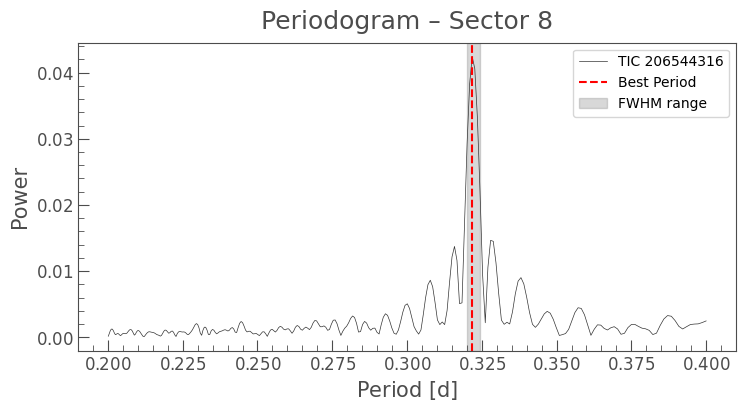


⎯⎯⎯⎯ Sector 9 ⎯⎯⎯⎯
Sector: 95


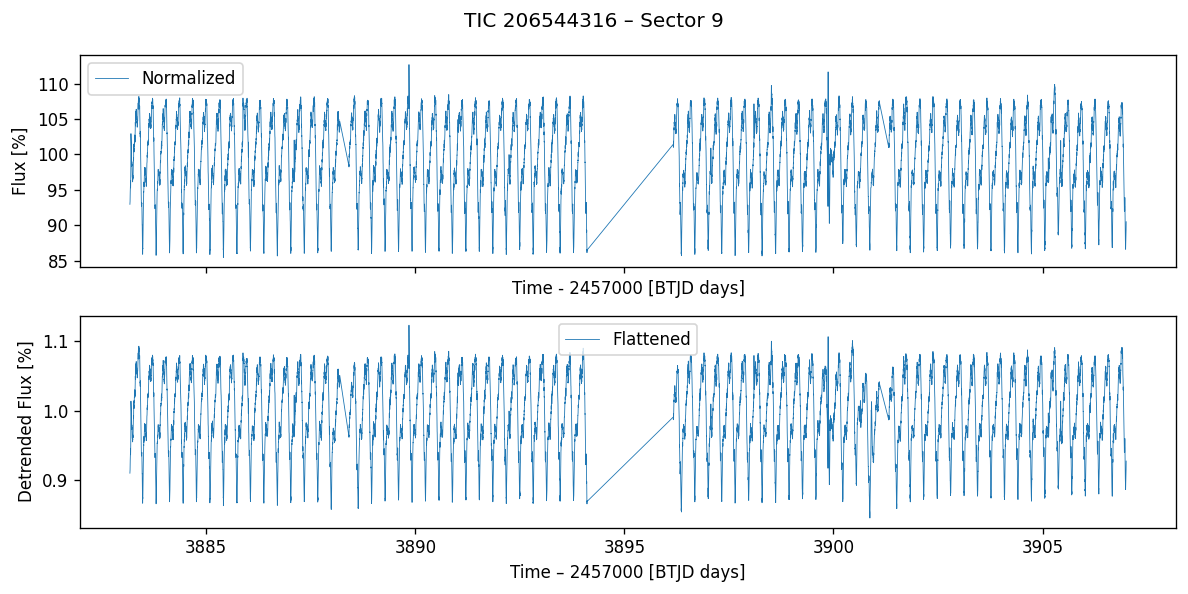

Best LS period: 0.3221 ±  0.001742 days


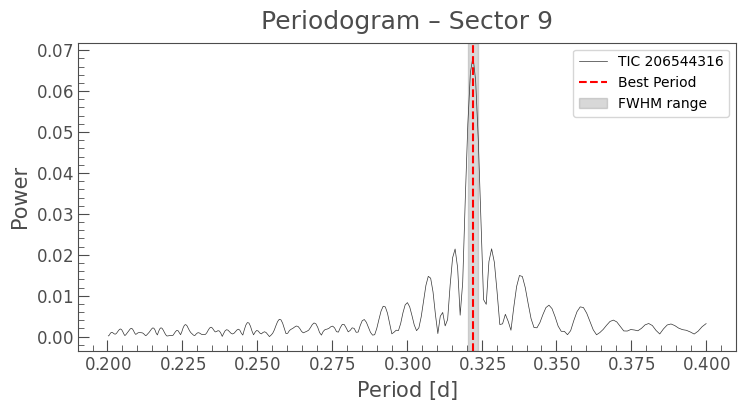


Summary Table of Periods:
   Sector  LS_period_d  LS_err_d
0       1     0.321571  0.001859
1       2     0.321986  0.001887
2      28     0.322105  0.001742
3      29     0.322347  0.002109
4      68     0.205364  0.096791
5      69     0.320079  0.080140
6      68     0.321701  0.002105
7      69     0.321792  0.002161
8      95     0.322124  0.001742

Saved table -> TIC206544316_periods_table.csv


In [1]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import pandas as pd

# Target TIC ID
tic_id = "206544316"

# Search for all SPOC light curves from TESS
sr = lk.search_lightcurve(f"TIC {tic_id}", mission="TESS", author="SPOC")

# Download light curves (PDCSAP_FLUX only)
lcs = sr.download_all(flux_column="pdcsap_flux", quality_bitmask="default")


results = []

# Loop over each sector
for i, lc_sector in enumerate(lcs):
    print(f"\n⎯⎯⎯⎯ Sector {i+1} ⎯⎯⎯⎯")
    print(f"Sector: {lc_sector.sector}")

    # Clean and normalize light curve
    lc_clean = lc_sector.normalize(unit="percent").remove_nans().remove_outliers(sigma=5)
    
    # Flatten for long-term trends
    lc_flat = lc_clean.flatten(window_length=401)

    # Plot raw and flattened lightcurve
    fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True, dpi=120)
    lc_clean.plot(ax=ax[0], label="Normalized")
    ax[0].set_ylabel("Flux [%]")
    ax[0].legend()
    
    lc_flat.plot(ax=ax[1], label="Flattened")
    ax[1].set_ylabel("Detrended Flux [%]")
    ax[1].set_xlabel("Time – 2457000 [BTJD days]")
    ax[1].legend()
    plt.suptitle(f"TIC {tic_id} – Sector {i+1}")
    plt.tight_layout()
    plt.show()

    # Lomb-Scargle periodogram
    periodogram = lc_flat.to_periodogram(method="lombscargle",
                                         minimum_period=0.2,
                                         maximum_period=0.4)
    
    best_period = periodogram.period_at_max_power.value
    best_power = periodogram.max_power.value

    # Estimate error using FWHM of the peak
    periods = periodogram.period.value
    powers = periodogram.power.value

    half_max = best_power / 2
    above_half = np.where(powers >= half_max)[0]
    
    if len(above_half) > 1:
        fwhm_range = periods[above_half]
        period_error = np.abs(fwhm_range[-1] - fwhm_range[0]) / 2
    else:
        period_error = np.nan  # can't estimate if peak is too sharp

    print(f"Best LS period: {best_period:.4f} ± {period_error: 4f} days")

    # Plot the periodogram
    periodogram.plot(title=f"Periodogram – Sector {i+1}")
    plt.axvline(best_period, color='r', linestyle='--', label="Best Period")
    if len(above_half) > 1:
        plt.axvspan(fwhm_range[0], fwhm_range[-1], color='gray', alpha=0.3, label='FWHM range')
    plt.legend()
    plt.show()

#Store result
    results.append({
        "Sector": lc_sector.sector,
        "LS_period_d": best_period,
        "LS_err_d": period_error
    })

# Convert to DataFrame
df = pd.DataFrame(results, columns=["Sector", "LS_period_d", "LS_err_d"])
print("\nSummary Table of Periods:")
print(df)

# Save to CSV
csvfile = f"TIC{tic_id}_periods_table.csv"
df.to_csv(csvfile, index=False)
print(f"\nSaved table -> {csvfile}")



<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

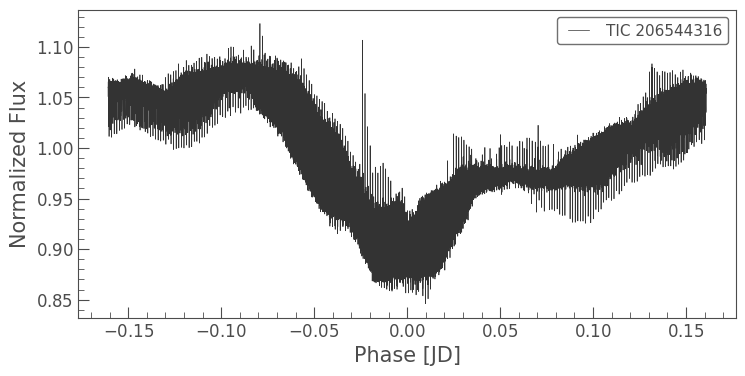

In [6]:
lc_fold_ls = lc_flat.fold(period= 0.32157)
lc_fold_ls.plot()


Text(0.5, 1.0, 'Phase-Folded Light Curve (Raw vs. Binned)')

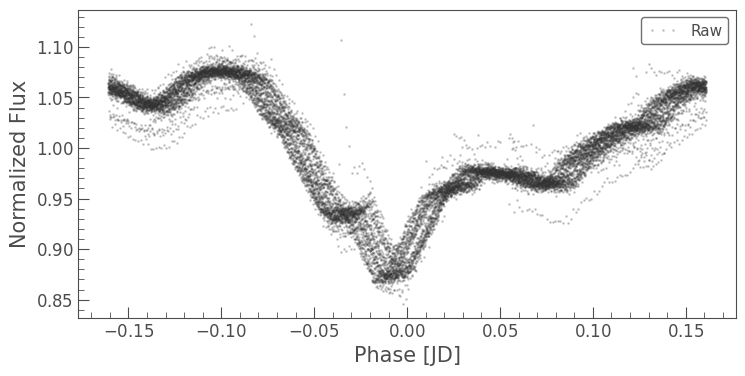

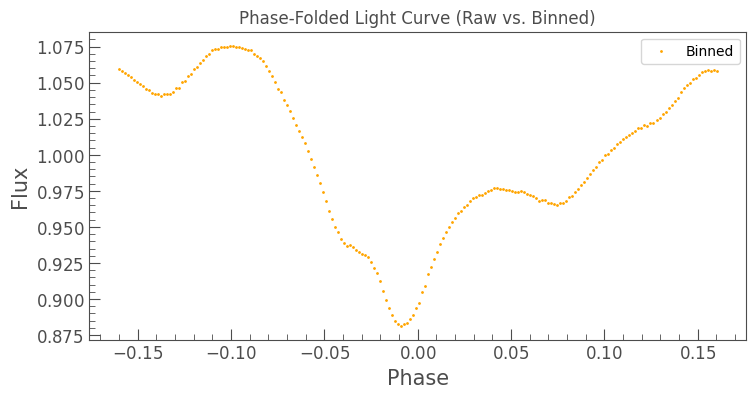

In [3]:
lc_fold_bin = lc_fold_ls.bin(bins=200)

lc_fold_ls.plot(alpha=0.2, label="Raw", marker='.', linestyle='none')  # raw data
lc_fold_bin.scatter(label="Binned", color="orange")  # binned data

plt.legend()
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.title("Phase-Folded Light Curve (Raw vs. Binned)")


In [4]:
import lightkurve as lk

# Example: search by TIC ID
search_result = lk.search_lightcurve("TIC 206544316", mission="TESS")
print(search_result)


SearchResult containing 35 data products.

 #     mission     year       author      exptime target_name distance
                                             s                 arcsec 
--- -------------- ---- ----------------- ------- ----------- --------
  0 TESS Sector 01 2018              SPOC     120   206544316      0.0
  1 TESS Sector 02 2018              SPOC     120   206544316      0.0
  2 TESS Sector 29 2020              SPOC     120   206544316      0.0
  3 TESS Sector 28 2020              SPOC     120   206544316      0.0
  4 TESS Sector 69 2023              SPOC      20   206544316      0.0
  5 TESS Sector 68 2023              SPOC      20   206544316      0.0
  6 TESS Sector 68 2023              SPOC     120   206544316      0.0
  7 TESS Sector 69 2023              SPOC     120   206544316      0.0
  8 TESS Sector 95 2025              SPOC     120   206544316      0.0
  9 TESS Sector 02 2018         TESS-SPOC    1800   206544316      0.0
 10 TESS Sector 01 2018         TE

In [5]:
import numpy as np

# Assume 'folded' is your folded light curve object
folded = lc_flat.fold(period= 0.3213)
amp = np.max(folded.flux.value) - np.min(folded.flux.value)
amp_percent = amp * 100
print(f"Peak-to-peak amplitude: {amp_percent:.2f}%")


Peak-to-peak amplitude: 27.69%
